In [1]:
import numpy as np
from devito import Grid, TimeFunction, Eq, solve, Operator, Constant
from sympy import nsimplify, symbols

# Viz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# initialize the grid
grid = Grid(shape=(100,), extent=(500e-9,)) # extent is in m

In [3]:
grid.dimensions

(x,)

In [4]:
# carrier density is a function of time and space
n = TimeFunction(name="n", grid=grid, space_order=2)
n

n(t, x)

In [5]:
n.dt

Derivative(n(t, x), t)

In [6]:
n.laplace

Derivative(n(t, x), (x, 2))

In [7]:
n.forward

n(t + dt, x)

In [8]:
# Create constants
D = Constant(name="D")
S1 = Constant(name="S1")
S2 = Constant(name="S2")
tau_b = Constant(name="tau_b")
k1 = Constant(name="k1")
k2 = Constant(name="k2")

In [9]:
# create the continuity equation
# eq = Eq(n.dt, ((D * n.laplace) - (k1 * n) - (k2 * n**2)), subdomain=grid.interior)
eq = Eq(n.dt, (D * n.laplace - n/tau_b), subdomain=grid.interior)
eq

Eq(Derivative(n(t, x), t), D*Derivative(n(t, x), (x, 2)) - n(t, x)/tau_b)

In [10]:
# create the stencil
stencil = solve(eq, n.forward) # solve for the next time step

# create equation out of the stencil
eq_stencil = Eq(n.forward, stencil, subdomain=grid.interior)

eq_stencil

Eq(n(t + dt, x), dt*(D*(-2.0*n(t, x)/h_x**2 + n(t, x - h_x)/h_x**2 + n(t, x + h_x)/h_x**2) - n(t, x)/tau_b + n(t, x)/dt))

In [23]:
# initial conditions - carrier density at t=0

# TODO find a better/elegant way to incorporate the exponential decay condition
x_ = np.linspace(0, grid.extent[0], grid.shape[0])

n.data[0] = 1e7 * np.exp(-x_/100e-9) # in carriers/m3

In [24]:
# Create boundary conditions

x, = grid.dimensions
t = grid.stepping_dim

bc = [ Eq(n[t+1, 0], (S1 / D) * n[t+1, 0] ) ] # left
bc += [ Eq(n[t+1, -1], -(S2 / D) * n[t+1, -1] ) ] # right

In [25]:
# Variable declarations

nt = 1 # time steps

dt = 1e-9 # size of the steps in s

In [33]:
# Create operator - create JIT-compiled and run C code

op = Operator([eq_stencil] + bc)

op(time=nt, dt=dt, D=0.9e-4, k1=1e7 * 1e-6, k2=1e-11 * 1e-12, S1=1e3 * 1e-2, S2=1e3 * 1e-2)
# op(time=nt, dt=dt, D=0.9e-4, S1=1e3 * 1e-2, S2=1e3 * 1e-2, tau_b=8e-6)

Operator `Kernel` run in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=2e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

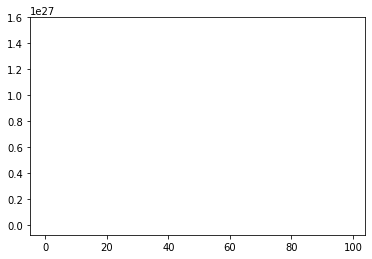

In [34]:
plt.plot(n.data[0])
# plt.yscale("log")

In [30]:
n.data

Data([[ 1.23456791e+17, -2.49528017e+22,  2.89795309e+22,
       -1.98988780e+22,  9.63689818e+21, -3.65978409e+21,
        1.17595636e+21, -3.29147760e+20,  8.15761454e+19,
       -1.81184002e+19,  3.63522898e+18, -6.60536627e+17,
        1.06238335e+17, -1.42004225e+16,  8.52230980e+15,
       -2.03902627e+16,  3.15995819e+16, -3.47813302e+16,
        2.98867984e+16, -2.22417802e+16,  1.75179465e+16,
       -1.64693162e+16,  1.57151039e+16, -1.33375904e+16,
        1.06830440e+16, -8.72414964e+15,  6.27925668e+15,
       -2.04979005e+15, -4.02640460e+15,  1.02740922e+16,
       -1.31853112e+16,  1.05462922e+16, -4.60388228e+15,
       -4.99966607e+14,  3.20800207e+15, -4.37854011e+15,
        4.63586851e+15, -3.96450070e+15,  2.83438314e+15,
       -2.43086854e+15,  3.58280293e+15, -5.50397428e+15,
        6.51022768e+15, -6.16632964e+15,  5.35962526e+15,
       -4.78067495e+15,  4.76780347e+15, -5.51311129e+15,
        6.50510646e+15, -6.93941141e+15,  6.77161294e+15,
       -6.3575

In [22]:
bc

[Eq(n[t + 1, 0], S1*n[t + 1, 0]/D), Eq(n[t + 1, x - 1], -S2*n[t + 1, x - 1]/D)]